## IMPORTING LIBRARIES

In [3]:
import itertools as it
from collections import defaultdict
import numpy as np
import urllib
import time
import random
import matplotlib.pyplot as plt
import math as math
import sys

## LOADING DATA

In [2]:
# Load the retail dataset from the URL, this will be used in lab 4, not lab 3
def load_data_from_url(url):
    response = urllib.request.urlopen(url)
    lines = response.readlines()
    dataset = [list(map(int, line.strip().split())) for line in lines]
    return dataset

dataset = load_data_from_url("http://fimi.uantwerpen.be/data/retail.dat")

## APRIORI ALGORITHM

In [3]:
set_counts = {}

def apriori(dataset, min_support) -> list:

    # TODO: Implement the Apriori algorithm
    
    # Pass 1: recording singleton support in dictionary
    # This generates C1
    C1 = defaultdict(int)
    for basket in dataset:
        for item in basket:
            C1[tuple((item,))] += 1
    
    
    # Pruning C1: removing infrequent singletons from dictionary
    # this generates L1
    items = tuple(C1)
    # if the item count is less than support, entry is removed from dictionary
    for item in items:
        if C1[item] < min_support:
            del C1[item]
    # defining frequent itemset map as L1
    L1 = C1
    # appending list of frequent singletons to frequent_sets
    set_counts.update(L1)
    
    
    # Generating candidate item pairs for C2 using singletons in L1
    frequent_singletons = [i for s in L1 for i in s]
    pairs = it.combinations(frequent_singletons,2)
    # initializing C2 with candidates
    C2 = {}
    for pair in pairs:
        C2[tuple(sorted(pair))] = 0


    # Pass 2: finding support of all candidate item pairs in C2
    for basket in dataset:
        for pair in it.combinations(basket,2):
            pair = tuple(sorted(pair))
            if pair in C2:
                C2[pair] += 1

    
    # Pruning: removing all infrequent item pairs from C2
    # this will generate L2
    pairs = tuple(C2)
    for pair in pairs:
        if C2[pair] < min_support:
            del C2[pair]
    L2 = C2
    # appending list of frequent pairs to frequent_sets
    set_counts.update(L2)
    
    frequent_sets = []
    for s in set_counts:
        frequent_sets.append(list(s))
    
    return frequent_sets

## BUCKET HASHING FUNCTION

In [4]:
# Hash function for PCY algorithm, do not modify this, should be used in the pcy_algorithm function
def hash_function(pair, num_buckets):
    i, j = pair
    hash_value = ((i * num_buckets) + j) % num_buckets
    return hash_value

## PCY ALGORITHM

In [5]:
def pcy_algorithm(dataset, min_support, hash_buckets) -> list:
    
    frequent_items = []

    # Pass 1: counting singletons and hashing pairs to buckets
    # each pair will be sorted in order to maintain consistent hashing for out of order pairs
    C1 = defaultdict(int)
    buckets = defaultdict(int)

    for basket in dataset:
        
        for i in basket:
            C1[i] += 1
            
        for p in it.combinations(basket,2):
            buckets[hash_function(sorted(p),hash_buckets)] += 1
    
    
    
    # Pruning C1 to create L1 for singletons
    # converting buckets to a bit-vector
    items = tuple(C1)
    
    for i in items:
        if C1[i] < min_support:
            del C1[i]
    
    # L1 is mapping of frequent singletons
    L1 = C1
    for i in L1:
        frequent_items.append([i])

    # converting buckets to a bit vector
    bitvector = 0
    for x in buckets:
        if(buckets[x] >= min_support):
            bitvector |= (1 << x)
            
    # delete redundant hashmap
    del buckets
    
    # Pass 2: Generating C2 using L1 and bit vector to reduce candidate pair list
    C2 = defaultdict(int)
    
    for basket in dataset:
    
        for p in it.combinations(basket,2):
    
            p = tuple(sorted(p))
            bucket_num = hash_function(p, hash_buckets)
    
            if( (p[0] in L1) and (p[1] in L1) and (bitvector & (1 << bucket_num))):
                C2[p] += 1

                
    # Appending all frequent candidate pairs
    for p in C2:
        frequent_items.append(list(p))


    return frequent_items

## COMPARING RUNTIMES

In [6]:
# generating a sequence of partitions of the dataset
# each partition is from the oth to nth basket
partitions = [0, 100, 500, 2000, 5000, 10000]

# with roughly 16000 unique items there are roughly 135 million possible unique item pairs
# each partition could potentially contain all or most unique item pairs
    # a fully populated dictionary with 100 million int:int entries takes up roughly 7GB of memory
    # a fully populated dictionary with 10 million int:int entries takes up roughly 0.83GB of memory
# thus we avoid many bucket collisions even if a high percentage of the potential pairs do exist in the partitions, 
NUM_BUCKETS = 10000000

# data points for graphing
x = [] # number of baskets
ap_y = [] # apriori runtime per basket
pcy_y = [] # pcy runtime per basket

for E in partitions:
    
    # extracting current dataset partition
    d = dataset[:E]
    support = 5
    
    ### RUNTIME OF APRIORI ###
    ap_start = time.time()
    apriori_freq_items = apriori(d, support)
    ap_end = time.time()
    
    ### RUNTIME OF PCY ###
    pcy_start = time.time()
    pcy_freq_items = pcy_algorithm(d, support, NUM_BUCKETS)
    pcy_end = time.time()
    
    x.append(E)
    ap_y.append((ap_end-ap_start)*1000)
    pcy_y.append((pcy_end-pcy_start)*1000)    
        

## PLOTTING DATA

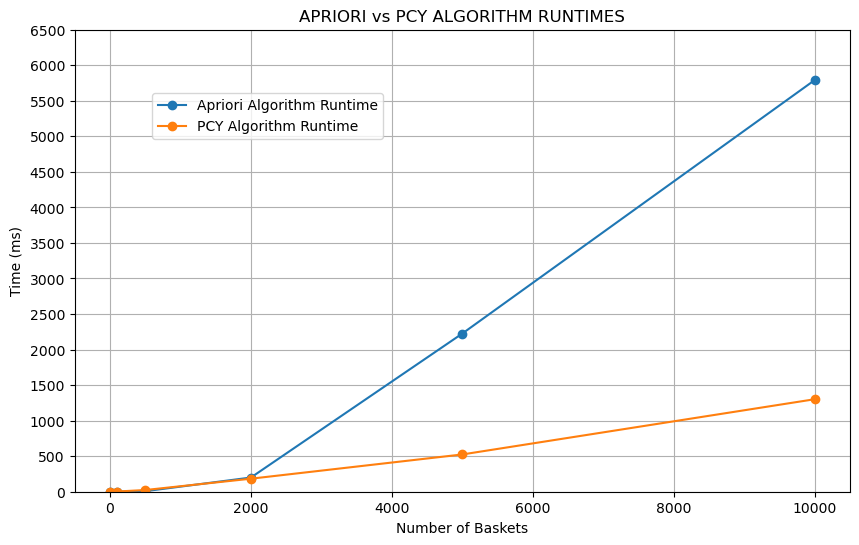

In [7]:
# Create a figure with 1 subplots
fig, ax = plt.subplots(figsize=(10,6))
# Plotting apriori runtimes
ax.plot(x, ap_y, '-o', label='Apriori Algorithm Runtime')
# Plotting pcy runtimes
ax.plot(x, pcy_y, '-o', label='PCY Algorithm Runtime')


# Adding labels and a title
ax.set_xlabel('Number of Baskets')
ax.set_ylabel('Time (ms)')
ax.set_title('APRIORI vs PCY ALGORITHM RUNTIMES')
ax.grid()
ax.set_ylim(0,max(pcy_y))
ax.set_yticks( range(0,round(max(pcy_y)+5500),500) )
ax.legend(loc=(0.1,0.763))

plt.show()

In [2]:
def random_jaccard(n,m):
    if(m > n):
        print("m must be <= n\n")
        return
    U = []
    for i in range(n):
        U.append(i)
    num_unique_sets = math.comb(n,m)
    S = [random.randint(0,num_unique_sets-1),False]
    T = [random.randint(0,num_unique_sets-1),False]
    index = 0
    for i in it.combinations(U,m):
        if (index == S[0]):
            S.append(i)
            S[1] = True
        if (index == T[0]):
            T.append(i)
            T[1] = True
        if (S[1] and T[1]):
            break
        index += 1
    S = set(S[2])
    T = set(T[2])
    return (len(S&T)/len(S|T))
    
def average_jaccard(iterations, n, m):
    total_sim = 0
    for i in range(iterations):
        total_sim += random_jaccard(n,m)
    return total_sim/iterations

def expected_jaccard(n,m):
    expected_sim = 0
    for k in range(max(0,2*m-n),m+1):
        expected_sim += (k/(2*m-k)) * (math.comb(n,k) * math.comb(n-k,m-k) * math.comb(n-m,m-k)) / math.comb(n,m)**2
    return expected_sim

In [9]:
# # solution1
# (k/(2*m-k)) * (math.comb(m,k) * math.comb(n-m,m-k)) / math.comb(n,m)

# # solution2
# (k/(2*m-k)) * (math.comb(n,k) * math.comb(n-k,m-k) * math.comb(n-m,m-k)) / math.comb(n,m)**2

In [5]:
n = 10
m = 4
its = 10000
print(f"Simulated average Jaccard similarity: {average_jaccard(its,n,m)}")
print(f"Calculated expected Jaccard similarity: {expected_jaccard(n,m)}")


Simulated average Jaccard similarity: 0.2706609523809644
Calculated expected Jaccard similarity: 0.27061224489795915
